# DB Comparison
This notebook compares data between badapple_classic and badapple2, with a focus on statistics between shared scaffolds.

# Setup

In [63]:
# define DB variables
ORIGINAL_DB_NAME = "badapple_classic"
ORIGINAL_DB_HOST = "localhost"
ORIGINAL_DB_USER = "<your_user>"
ORIGINAL_DB_PASSWORD = "<your_password>"

COMPARISON_DB_NAME = "badapple2"
COMPARISON_DB_HOST = ORIGINAL_DB_HOST
COMPARISON_DB_USER = ORIGINAL_DB_USER
COMPARISON_DB_PASSWORD = ORIGINAL_DB_PASSWORD

In [64]:
# imports
import psycopg2
import psycopg2.extras
from psycopg2 import sql
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import seaborn as sns

## Connect to DBs

In [65]:
def db_connect(db_name: str, host: str, user: str, password: str):
    try:
        db_connection = psycopg2.connect(
            dbname=db_name,
            host=host,
            user=user,
            password=password,
            cursor_factory=psycopg2.extras.DictCursor,
        )
        db_connection.set_session(readonly=True)
        return db_connection
    except Exception as e:
        print(e)
        print(f"Error connecting to DB: {db_name}")
        return None

In [66]:
original_db_connection = db_connect(ORIGINAL_DB_NAME, ORIGINAL_DB_HOST, ORIGINAL_DB_USER, ORIGINAL_DB_PASSWORD)
comparison_db_connection = db_connect(COMPARISON_DB_NAME, COMPARISON_DB_HOST, COMPARISON_DB_USER, COMPARISON_DB_PASSWORD)

In [67]:
original_db_cur = original_db_connection.cursor()
comparison_db_cur = comparison_db_connection.cursor()

# View metadata
Medians/overall stats.

In [68]:
def get_summary_stats(db_cursor, db_conn):
    query = sql.SQL("SELECT median_ncpd_tested,median_nsub_tested,median_nass_tested,median_nsam_tested,nass_total FROM metadata")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result[0] # only 1 row
    except Exception:
        db_conn.rollback()
    return result

In [69]:
original_stats = get_summary_stats(original_db_cur, original_db_connection)
comparison_stats = get_summary_stats(comparison_db_cur, comparison_db_connection)

In [70]:
stat_diff = list(np.array(comparison_stats) - np.array(original_stats))
columns = ["source","median_ncpd_tested","median_nsub_tested","median_nass_tested","median_nsam_tested","nass_total"]
rows = [[f"{ORIGINAL_DB_NAME}"] + original_stats, [f"{COMPARISON_DB_NAME}"] + comparison_stats, ["diff"] + stat_diff]
summary_df = pd.DataFrame(rows, columns=columns)

In [71]:
summary_df

,source,median_ncpd_tested,median_nsub_tested,median_nass_tested,median_nsam_tested,nass_total
0,badapple_classic,2,2,633,773,823
1,badapple2,1,2,8,11,906
2,diff,-1,0,-625,-762,83


# pScore Comparison
Note: Have validated through [validate_pScore_differences.sql](../sql/validate_pScore_differences.sql) that in all cases where pScores differ the scaffold statistics (nsub_tested, nsub_active, etc) also differ (as expected).

In [72]:
ORIGINAL_PSCORE_COL_NAME = f"pScore {ORIGINAL_DB_NAME}"
COMPARISON_PSCORE_COL_NAME = f"pScore {COMPARISON_DB_NAME}"

In [73]:
def get_pScores(db_cursor, db_conn):
    query = sql.SQL("SELECT scafsmi, pScore FROM scaffold order by scafsmi")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception:
        db_conn.rollback()
    return result

In [74]:
original_pScores = get_pScores(original_db_cur, original_db_connection)
comparison_pScores = get_pScores(comparison_db_cur, comparison_db_connection)

In [75]:
def get_pScore_df(pScore_list: list[list[str, int]], dropna: bool = True):
    df = pd.DataFrame(pScore_list, columns=['scafsmi', 'pScore'])
    if dropna:
        # some compounds in badapple+badapple_classic have 'None' as pScore (no evidence)
        # this is because the compound list was from MLSMR, not from the set of compounds in the assays
        # drop these scores as it does not make sense to try and compare these NaN cases
        df.dropna(subset="pScore", inplace=True)
    return df

In [76]:
original_df = get_pScore_df(original_pScores, False)
comparison_df = get_pScore_df(comparison_pScores, False)

In [77]:
# get df containing shared scaffolds
shared_df = pd.merge(original_df, comparison_df, on='scafsmi')
shared_df.rename(columns={"pScore_x": ORIGINAL_PSCORE_COL_NAME, "pScore_y": COMPARISON_PSCORE_COL_NAME}, inplace=True)
# doesn't make sense to compare NaN entries
shared_df = shared_df[~(shared_df[ORIGINAL_PSCORE_COL_NAME].isna()| shared_df[COMPARISON_PSCORE_COL_NAME].isna())]

In [78]:
shared_df

,scafsmi,pScore badapple_classic,pScore badapple2
1,[BH2-](c1ccccc1)c1ccccc1,10.0,3.0
2,C1C2C1C1C3CC4C(C23)C41,0.0,0.0
3,C1C2C3C4OC5C3C1C1C2C4C51,0.0,0.0
4,C1C2C3CC4C5CC(C1C35)C24,4.0,2.0
5,C1=C2C3CCC4CC3C(CC2C2CCC3CCCCC3C2C1)O4,0.0,0.0
...,...,...,...
142877,S=P(NCCNP(=S)(N1CC1)N1CC1)(N1CC1)N1CC1,0.0,0.0
142878,S=P(NCCSCc1ccccc1)(N1CC1)N1CC1,1.0,1.0
142879,S=P(N=CN1CCOCC1)(N1CCOCC1)N1CCOCC1,0.0,0.0
142880,S=P(Nn1cnnc1)(c1ccccc1)c1ccccc1,0.0,0.0


## Parity plot

In [79]:
def create_parity_plot(df: pd.DataFrame, x_col: str, y_col: str, title: str=None):
    plt.style.use('ggplot')
    plt.scatter(df[x_col], df[y_col], alpha=0.5)
    # Create parity line
    plt.plot(df[x_col], df[x_col], color='black')
    ax = plt.gca()
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()

In [80]:
# use scipy to calculate correlation + pval
correlation, p_value = pearsonr(shared_df[ORIGINAL_PSCORE_COL_NAME], shared_df[COMPARISON_PSCORE_COL_NAME])

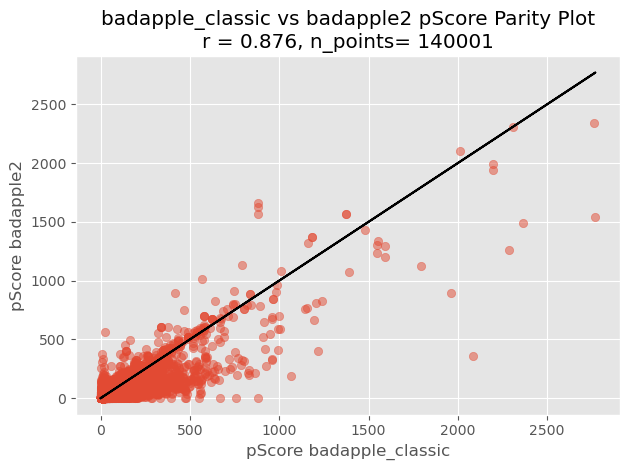

In [81]:
# visualize parity plot 
plot_title = f"{ORIGINAL_DB_NAME} vs {COMPARISON_DB_NAME} pScore Parity Plot\nr = %.3f, n_points= %d" % (correlation, len(shared_df))
create_parity_plot(shared_df, ORIGINAL_PSCORE_COL_NAME, COMPARISON_PSCORE_COL_NAME, plot_title)
plt.show()

## pScore Rankings

In [82]:
shared_df["classic_rank"] = shared_df[ORIGINAL_PSCORE_COL_NAME].rank()
shared_df["2_rank"] = shared_df[COMPARISON_PSCORE_COL_NAME].rank()

In [83]:
shared_df["rank_diff"] = shared_df["classic_rank"] - shared_df["2_rank"]

In [84]:
def plot_histogram(df: pd.DataFrame, column: str, bins, xlabel: str, ylabel: str, title: str, yscale: str = "linear", plot_percentage: bool = False, pct_decimals: int =2):
    data = df[column]
    weights = None
    if plot_percentage:
        weights = np.ones(len(data)) / len(data)
    plt.hist(df[column], weights=weights, bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale(yscale)
    if plot_percentage:
        plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=pct_decimals))
    title += f"\nN={len(data)}"
    plt.title(title)
    plt.show()

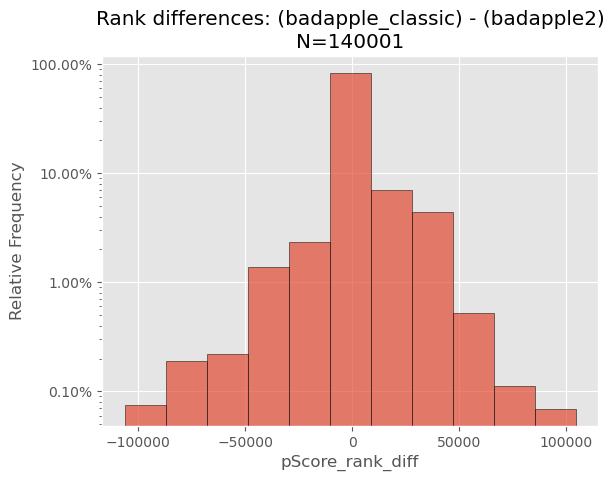

In [85]:
title = f'Rank differences: ({ORIGINAL_DB_NAME}) - ({COMPARISON_DB_NAME})'
plot_histogram(shared_df, "rank_diff", 11, "pScore_rank_diff", "Relative Frequency", title, yscale="log", plot_percentage=True)

In [86]:
SCAF_COL_STR = "scafsmi,nsub_tested,nsub_active,nass_tested,nass_active,nsam_tested,nsam_active"
SCAF_COL_LIST = SCAF_COL_STR.split(",")

## pScore Histograms

In [87]:
def show_score_histogram(pScore_values: pd.Series, db_source: str):
    # map NaN values to -1 for sake of plotting
    pScore_values.fillna(-1, inplace=True)
    # Define the ranges and corresponding colors
    ranges = [(-float('inf'), 0), (0, 100), (100, 300), (300, float('inf'))]
    colors = ['grey', 'green', 'yellow', 'red']
    labels = ['pScore = ~', '0 <= pScore < 100', '100 <= pScore < 300', 'pScore >= 300']

    # Create lists to hold the pScore values for each range
    pScore_lists = [[] for _ in ranges]
    counts = [0] * len(ranges)

    # Distribute the pScore values into the corresponding lists
    for pScore in pScore_values:
        for i, (low, high) in enumerate(ranges):
            if low <= pScore < high:
                pScore_lists[i].append(pScore)
                counts[i] += 1
                break
    
    # Define the bin edges in increments of 25
    bin_size = 25
    # min score is 0
    bin_edges = np.arange(-bin_size, max(pScore_values) + bin_size, bin_size)

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    for pScore_list, color in zip(pScore_lists, colors):
        plt.hist(pScore_list, bins=bin_edges, color=color, edgecolor='black', alpha=0.7)

    plt.xlabel('pScore')
    plt.ylabel('Frequency')
    plt.yscale("log")
    plt.title(f'Histogram of pScore Values from {db_source}\nBin Size={bin_size}')

    total_count = len(pScore_values)
    pct = lambda count : "%.2f" % ((100 * count) / total_count)
    legend_labels = [f'{label} : {count} ({pct(count)}%)' for label, count in zip(labels, counts)]
    legend_title = f"Counts (Total={total_count})"
    plt.legend(legend_labels, title=legend_title, loc='upper right')

    plt.show()

### badapple_classic

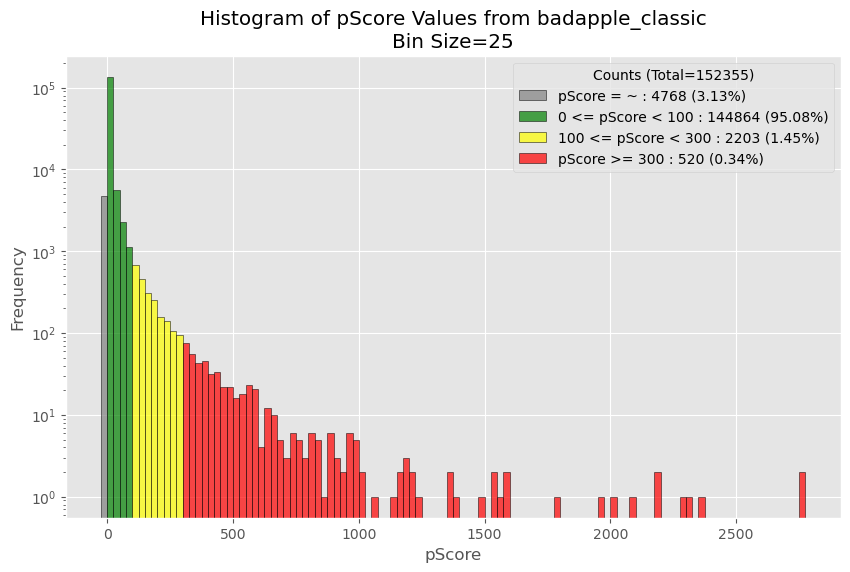

In [88]:
show_score_histogram(original_df["pScore"], f"{ORIGINAL_DB_NAME}")

### badapple2

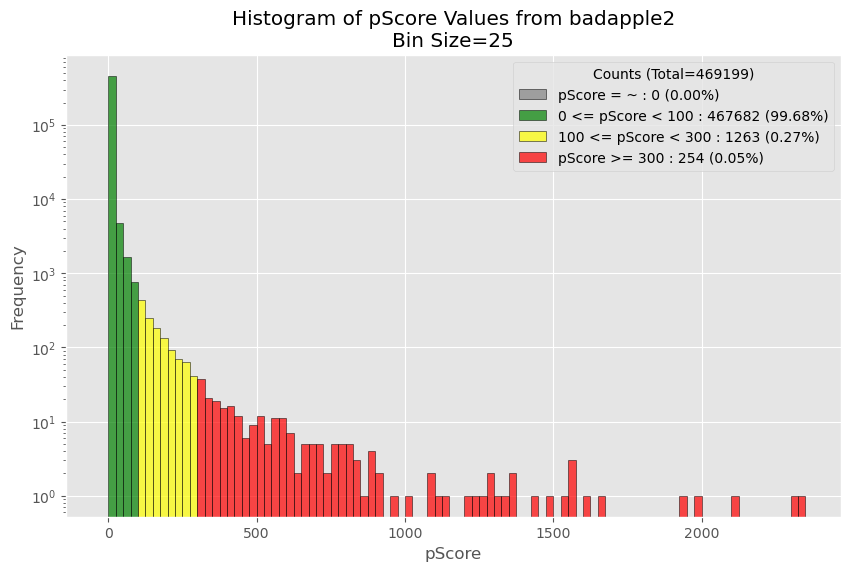

In [89]:
show_score_histogram(comparison_df["pScore"], f"{COMPARISON_DB_NAME}")

### Shared Scaffolds
pScore histograms from shared scaffolds (combined by canonical SMILES). NaN scores removed.

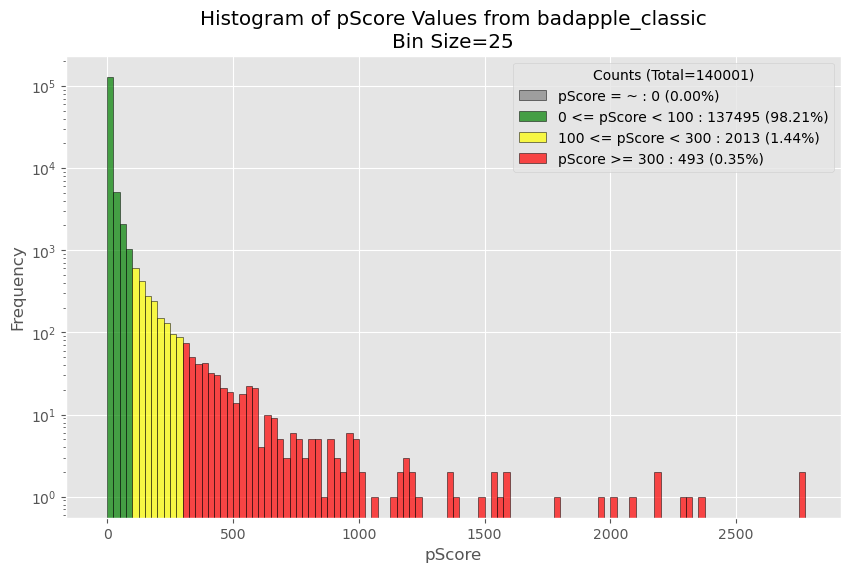

In [90]:
show_score_histogram(shared_df[ORIGINAL_PSCORE_COL_NAME], f"{ORIGINAL_DB_NAME}")

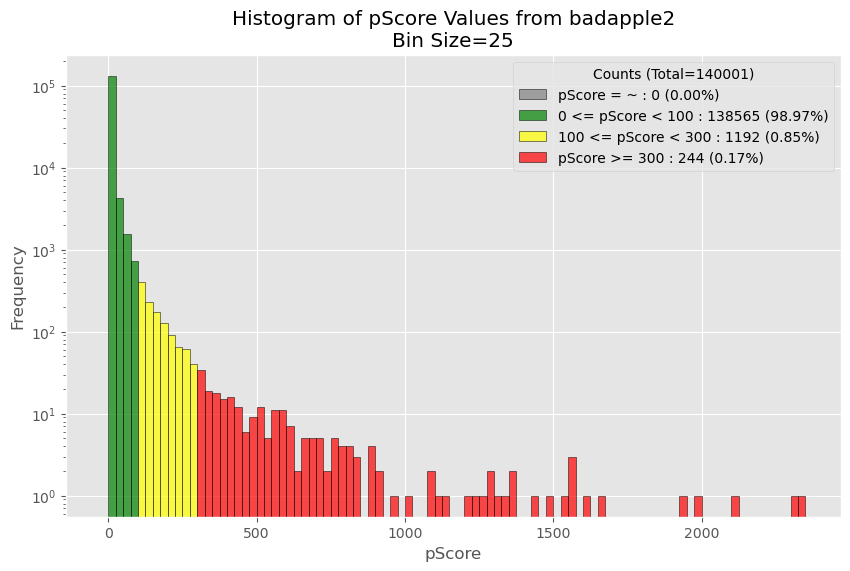

In [91]:
show_score_histogram(shared_df[COMPARISON_PSCORE_COL_NAME], f"{COMPARISON_DB_NAME}")

### Difference Histogram
Visualize changes in pScore of scaffolds from badapple_classic to badapple2.

In [92]:
shared_df["pScore_diff"] = shared_df[ORIGINAL_PSCORE_COL_NAME] - shared_df[COMPARISON_PSCORE_COL_NAME]

In [93]:
# number of entries with no pScore difference
def float_equals(a: float, b: float, epsilon: float=1e-9):
    return abs(a - b) < epsilon

no_pScore_diff_count = len(shared_df[float_equals(shared_df["pScore_diff"], 0)])
no_pScore_diff_pct = round((no_pScore_diff_count / len(shared_df)) * 100.0, 2)
print(f"N. entries with no difference in pScore: {no_pScore_diff_count} ({no_pScore_diff_pct}%)")

N. entries with no difference in pScore: 88923 (63.52%)


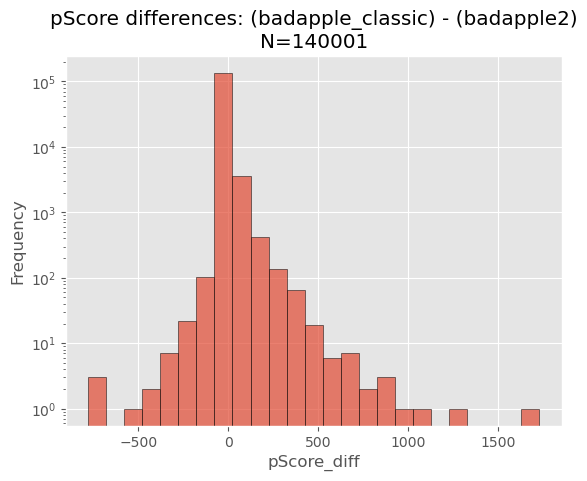

In [94]:
title = f'pScore differences: ({ORIGINAL_DB_NAME}) - ({COMPARISON_DB_NAME})'
plot_histogram(shared_df, "pScore_diff", 25, "pScore_diff", "Frequency", title, yscale="log", plot_percentage=False)

In [95]:
# create table
pScore_diff_bins = [-10000, -500, -200, -100, -75, -50, -25, 0, 25, 50, 75, 100, 200, 500, 10000]
shared_df["pScore_diff_bin"] = pd.cut(shared_df["pScore_diff"], bins=pScore_diff_bins)

In [96]:
pScore_diff_vcounts = shared_df["pScore_diff_bin"].value_counts(sort=False)
total = sum(pScore_diff_vcounts)
print(f"N={total}\n")
max_range_len = len("(-10000, -500]")
max_cnt_len = len("101685")
for pScore_range, cnt in pScore_diff_vcounts.items():
    pct = round(cnt/total * 100, 3)
    s = str(pScore_range)
    s2 = str(cnt)
    padding = " " * (max_range_len - len(s))
    padding2 = " " * (max_cnt_len - len(s2))
    print(f"{s + padding} | {s2 + padding2} | {pct}%")

N=140001

(-10000, -500] | 4      | 0.003%
(-500, -200]   | 25     | 0.018%
(-200, -100]   | 56     | 0.04%
(-100, -75]    | 63     | 0.045%
(-75, -50]     | 144    | 0.103%
(-50, -25]     | 408    | 0.291%
(-25, 0]       | 101685 | 72.632%
(0, 25]        | 33812  | 24.151%
(25, 50]       | 1860   | 1.329%
(50, 75]       | 695    | 0.496%
(75, 100]      | 386    | 0.276%
(100, 200]     | 559    | 0.399%
(200, 500]     | 277    | 0.198%
(500, 10000]   | 27     | 0.019%


## pScore Transitions
Cases where pScore went from "low" to moderate", "low" to "high", etc

In [97]:
def classify_pScore(pScore):
    if pScore < 100:
        return "low"
    elif pScore < 300:
        return "moderate"
    else:
        return "high"

In [98]:
# Classify the pScores for both databases
shared_df["classic_class"] = shared_df[ORIGINAL_PSCORE_COL_NAME].apply(classify_pScore)
shared_df["new_class"] = shared_df[COMPARISON_PSCORE_COL_NAME].apply(classify_pScore)

# Create a column for transitions
shared_df["transition"] = shared_df["classic_class"] + " -> " + shared_df["new_class"]

#### Bar Chart

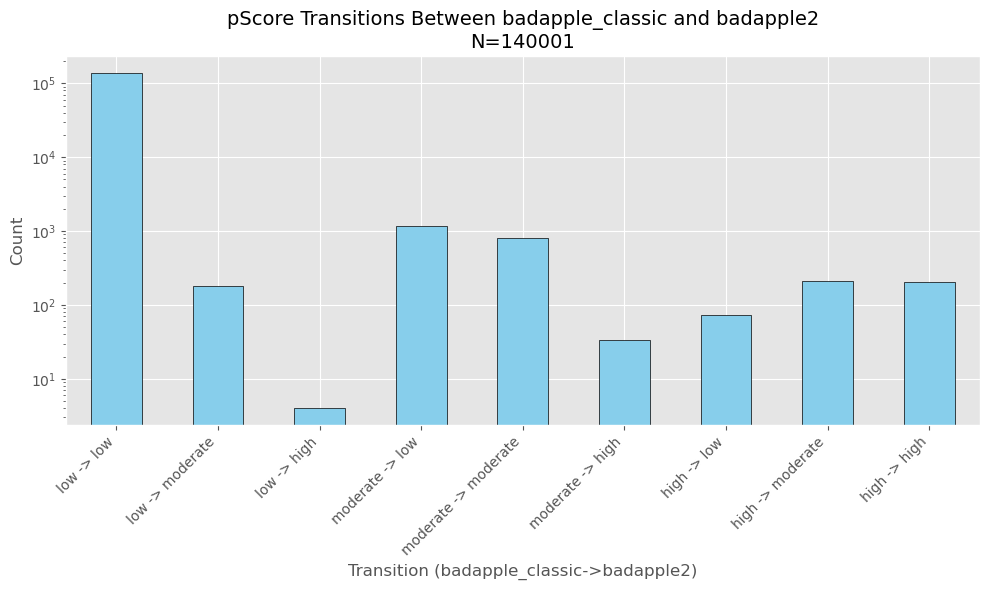

In [99]:
# Bar chart
desired_order = [
    "low -> low", "low -> moderate", "low -> high",
    "moderate -> low", "moderate -> moderate", "moderate -> high",
    "high -> low", "high -> moderate", "high -> high"
]
# Convert the 'transition' column to a categorical with the desired order
shared_df["transition"] = pd.Categorical(
    shared_df["transition"], categories=desired_order, ordered=True
)

# Count the occurrences of each transition and sort by the desired order
transition_counts = shared_df["transition"].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(10, 6))
transition_counts.sort_index().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title(f"pScore Transitions Between {ORIGINAL_DB_NAME} and {COMPARISON_DB_NAME}\nN={transition_counts.sum()}", fontsize=14)
plt.xlabel(f"Transition ({ORIGINAL_DB_NAME}->{COMPARISON_DB_NAME})", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Heatmap

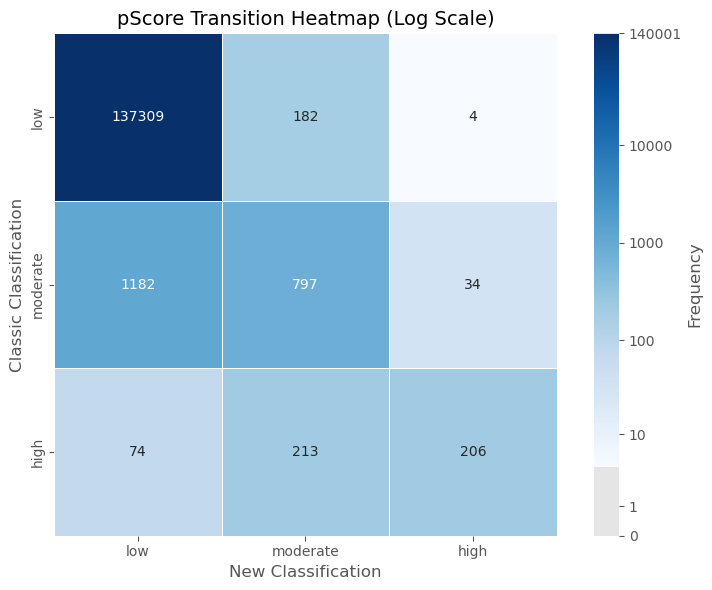

In [100]:
# Heatmap

# Create a transition matrix
desired_order = ["low", "moderate", "high"]
transition_matrix = (
    shared_df.groupby(["classic_class", "new_class"])
    .size()
    .unstack(fill_value=0)
)
transition_matrix = transition_matrix.reindex(index=desired_order, columns=desired_order)


# Logarithmic transformation of the transition matrix
log_transition_matrix = np.log1p(transition_matrix)  # log1p to handle zeros (log(1 + x))

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    log_transition_matrix,
    annot=transition_matrix,  # Show original counts as annotations
    fmt="d",
    cmap="Blues",
    cbar_kws={"label": "Frequency"},
    linewidths=0.5,
    square=True
)

# Customize the colorbar ticks
colorbar = plt.gca().collections[0].colorbar
original_ticks = [0, 1, 10, 100, 1000, 10000, sum(transition_matrix.sum())]
log_ticks = np.log1p(original_ticks)
colorbar.set_ticks(log_ticks)
colorbar.set_ticklabels(original_ticks)

plt.title(f"pScore Transition Heatmap (Log Scale)", fontsize=14)
plt.xlabel("New Classification", fontsize=12)
plt.ylabel("Classic Classification", fontsize=12)
plt.tight_layout()
plt.show()

## Compare inDrug pScores
This section compares the scores for scaffolds which were found to be present in approved drugs from [DrugCentral](https://drugcentral.org/).

### Get pScores of indrug scaffolds

In [101]:
def get_pScores_ind(db_cursor, db_conn):
    query = sql.SQL("SELECT scafsmi, pScore FROM scaffold WHERE in_drug ORDER BY scafsmi")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception:
        db_conn.rollback()
    return result

In [102]:
original_pScores_ind = get_pScores_ind(original_db_cur, original_db_connection)
comparison_pScores_ind = get_pScores_ind(comparison_db_cur, comparison_db_connection)

In [103]:
original_df_ind = get_pScore_df(original_pScores_ind, dropna=False)
comparison_df_ind = get_pScore_df(comparison_pScores_ind, dropna=False)

In [104]:
# get df containing shared scaffolds
shared_df_ind = pd.merge(original_df_ind, comparison_df_ind, on='scafsmi')
shared_df_ind.rename(columns={"pScore_x": ORIGINAL_PSCORE_COL_NAME, "pScore_y": COMPARISON_PSCORE_COL_NAME}, inplace=True)

# drop entries where pScore was NaN
shared_df_ind = shared_df_ind[~(shared_df_ind[ORIGINAL_PSCORE_COL_NAME].isna() | shared_df_ind[COMPARISON_PSCORE_COL_NAME].isna())]

In [105]:
shared_df_ind

,scafsmi,pScore badapple_classic,pScore badapple2
0,C1=C2c3cccc4[nH]cc(c34)CC2NCC1,280.0,186.0
1,C1C2CC3CC1CC(C2)C3,229.0,56.0
2,c1c2c(cc3c1OCO3)CCCC2,1.0,0.0
3,c1c2c(cc3c1OCO3)CNCC2,2.0,2.0
4,C1=C2CCC3C4CCCC4CCC3C2Cc2cnoc21,3.0,3.0
...,...,...,...
2221,S=C(Nc1ccccc1)Nc1ccccc1,161.0,78.0
2222,S=C(Nc1ccccc1)Oc1ccc2ccccc2c1,1.0,0.0
2224,S=C(Nc1ccc(Nc2ccccc2)cc1)N1CCNCC1,0.0,0.0
2225,S=[PH](N1CC1)N1CC1,10.0,7.0


### Parity Plot for shared indrug scafs

In [106]:
# use scipy to calculate correlation + pval
correlation_ind, p_value_ind = pearsonr(shared_df_ind[ORIGINAL_PSCORE_COL_NAME], shared_df_ind[COMPARISON_PSCORE_COL_NAME])

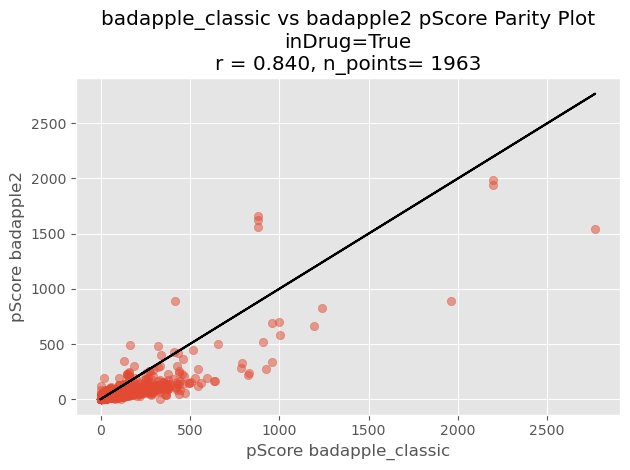

In [107]:
# visualize parity plot
plot_title = f"{ORIGINAL_DB_NAME} vs {COMPARISON_DB_NAME} pScore Parity Plot\ninDrug=True\nr = %.3f, n_points= %d" % (correlation_ind, len(shared_df_ind))
create_parity_plot(shared_df_ind, ORIGINAL_PSCORE_COL_NAME, COMPARISON_PSCORE_COL_NAME, plot_title)
plt.show()

### Histogram of scores

#### Original DB (badapple_classic)

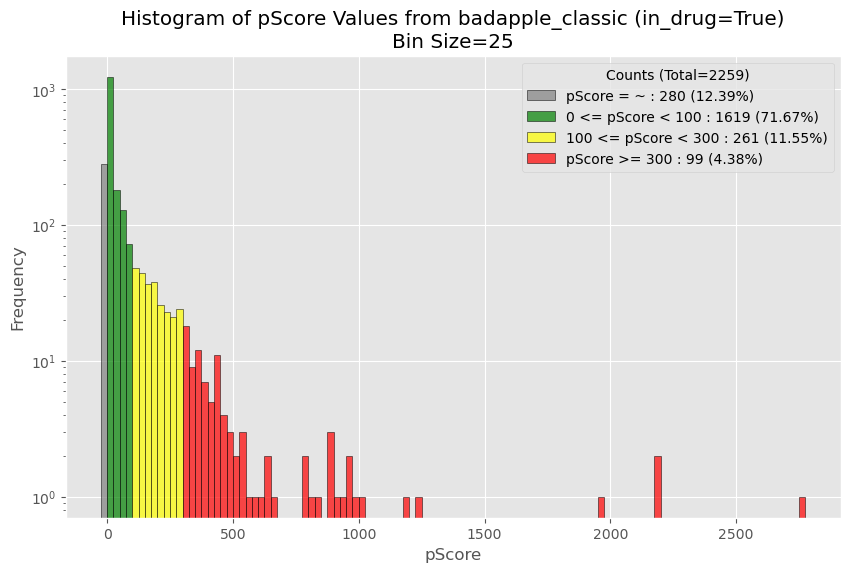

In [108]:
show_score_histogram(original_df_ind["pScore"], f"{ORIGINAL_DB_NAME} (in_drug=True)")

#### New DB (badapple2)

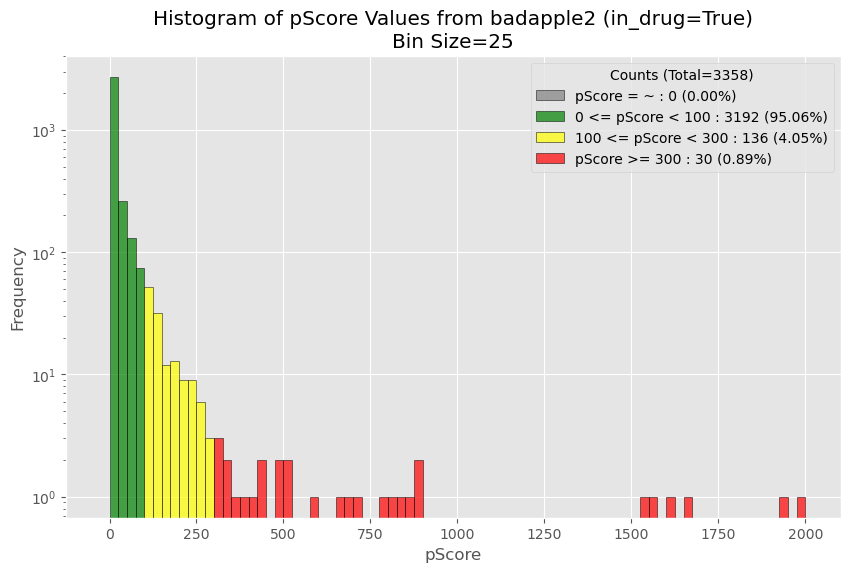

In [109]:
show_score_histogram(comparison_df_ind["pScore"], f"{COMPARISON_DB_NAME} (in_drug=True)")

#### Histogram of shared inDrug scaffolds

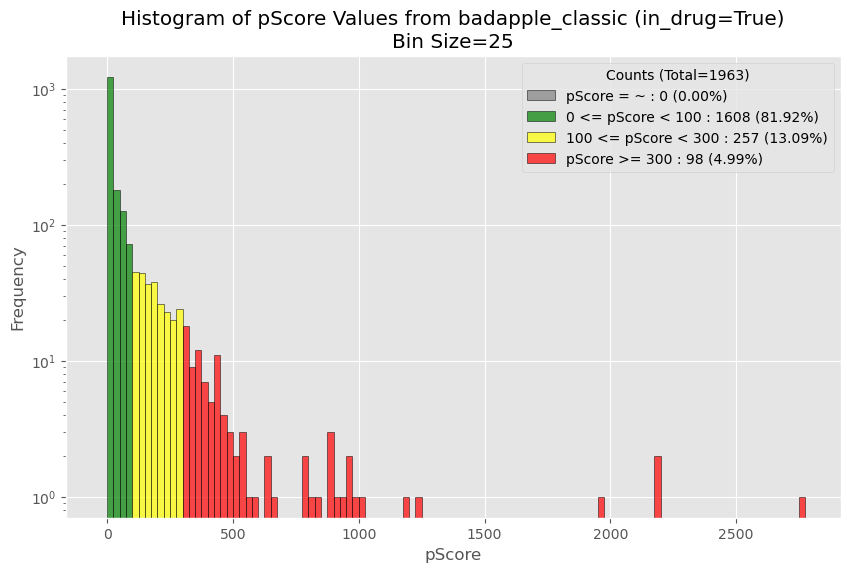

In [110]:
show_score_histogram(shared_df_ind[ORIGINAL_PSCORE_COL_NAME], f"{ORIGINAL_DB_NAME} (in_drug=True)")

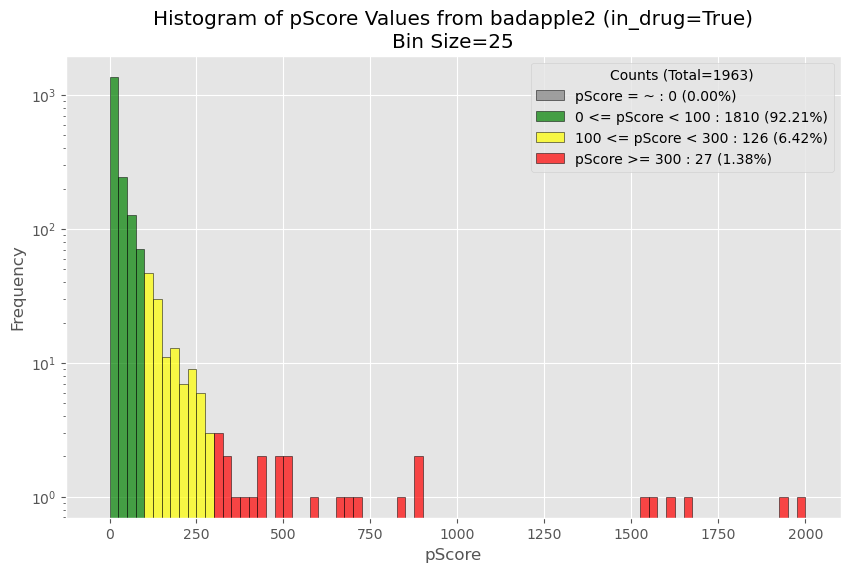

In [111]:
show_score_histogram(shared_df_ind[COMPARISON_PSCORE_COL_NAME], f"{COMPARISON_DB_NAME} (in_drug=True)")

# Batting Average Comparison
Here "batting average" refers to the (non-normalized) ratio of
active/tested statistics for substances,assays, and wells (ie samples).

In [112]:
ORIGINAL_BATTING_AVG_COL_NAME = f"batting_avg {ORIGINAL_DB_NAME}"
COMPARISON_BATTING_AVG_COl_NAME = f"batting_avg {COMPARISON_DB_NAME}"

In [113]:
def compute_batting_avg(
    row
) -> float:
    sTested = row["nsub_tested"]
    sActive = row["nsub_active"]
    aTested = row["nass_tested"]
    aActive = row["nass_active"]
    wTested = row["nsam_tested"]
    wActive = row["nsam_active"]
    if sTested == 0 or aTested == 0 or wTested == 0:
        return None  # None means no evidence

    batting_avg = (
        1.0
        * sActive
        / (sTested)
        * aActive
        / (aTested)
        * wActive
        / (wTested)
    )
    return batting_avg

In [114]:
def get_scaf_stats(db_cursor, db_conn):
    query = sql.SQL(f"SELECT {SCAF_COL_STR} FROM scaffold order by scafsmi")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception as e:
        print(e)
        db_conn.rollback()
    return result

In [115]:
def get_batting_avg_df(pScore_list: list[list[str, int]]):
    df = pd.DataFrame(pScore_list, columns=SCAF_COL_LIST)
    df["batting_avg"] = df.apply(compute_batting_avg, axis=1)
    df.dropna(subset="batting_avg", inplace=True)
    return df

In [116]:
original_scaf_stats = get_scaf_stats(original_db_cur, original_db_connection)
comparison_scaf_stats = get_scaf_stats(comparison_db_cur, comparison_db_connection)

In [117]:
original_batting_avg_df = get_batting_avg_df(original_scaf_stats)
comparison_batting_avg_df = get_batting_avg_df(comparison_scaf_stats)

In [118]:
# remove stats
original_batting_avg_df = original_batting_avg_df[["scafsmi", "batting_avg"]]
comparison_batting_avg_df = comparison_batting_avg_df[["scafsmi", "batting_avg"]]

In [119]:
# get df containing shared scaffolds
shared_batting_avg_df = pd.merge(original_batting_avg_df, comparison_batting_avg_df, on='scafsmi')
shared_batting_avg_df.rename(columns={"batting_avg_x": ORIGINAL_BATTING_AVG_COL_NAME, "batting_avg_y": COMPARISON_BATTING_AVG_COl_NAME}, inplace=True)

## Histograms

### badapple_classic

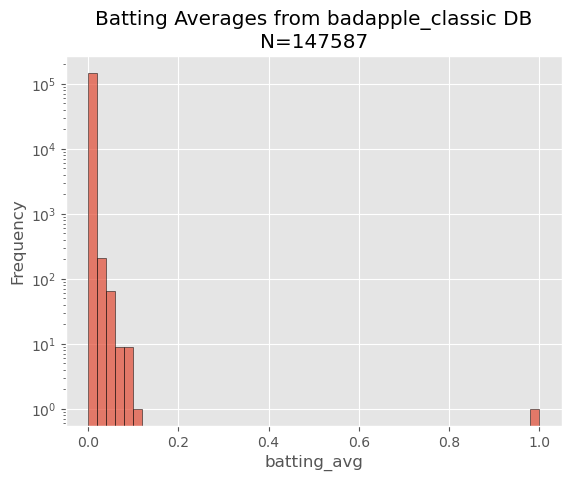

In [120]:
title = f"Batting Averages from {ORIGINAL_DB_NAME} DB"
plot_histogram(original_batting_avg_df, "batting_avg", 50, "batting_avg", "Frequency", title, yscale="log")

### badapple2

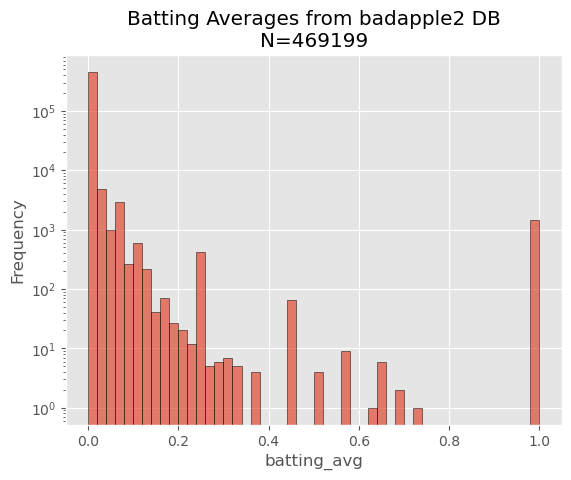

In [121]:
title = f"Batting Averages from {COMPARISON_DB_NAME} DB"
plot_histogram(comparison_batting_avg_df, "batting_avg", 50, "batting_avg", "Frequency", title, yscale="log")

### Shared Scaffolds

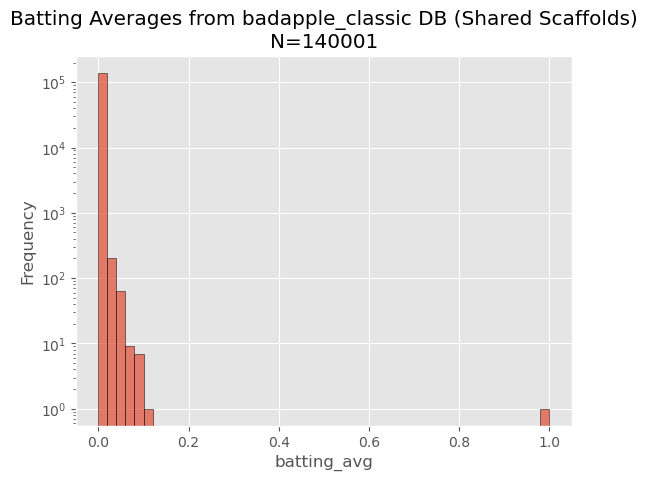

In [122]:
title = f"Batting Averages from {ORIGINAL_DB_NAME} DB (Shared Scaffolds)"
plot_histogram(shared_batting_avg_df, ORIGINAL_BATTING_AVG_COL_NAME, 50, "batting_avg", "Frequency", title, yscale="log")

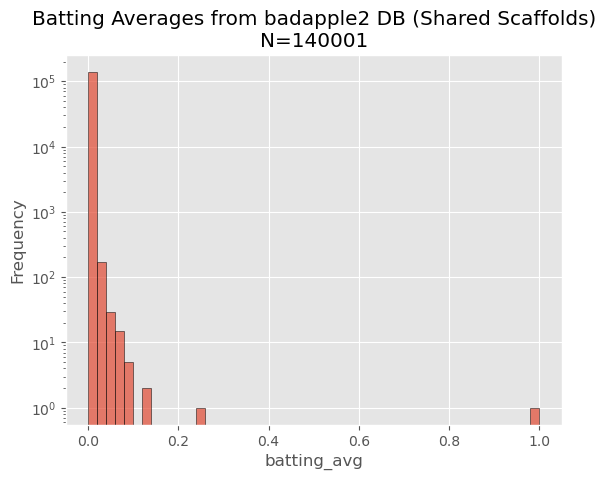

In [123]:
title = f"Batting Averages from {COMPARISON_DB_NAME} DB (Shared Scaffolds)"
plot_histogram(shared_batting_avg_df, COMPARISON_BATTING_AVG_COl_NAME, 50, "batting_avg", "Frequency", title, yscale="log")

## Parity Plot

In [124]:
# use scipy to calculate correlation + pval
correlation_nn, p_value_nn = pearsonr(shared_batting_avg_df[ORIGINAL_BATTING_AVG_COL_NAME], shared_batting_avg_df[COMPARISON_BATTING_AVG_COl_NAME])

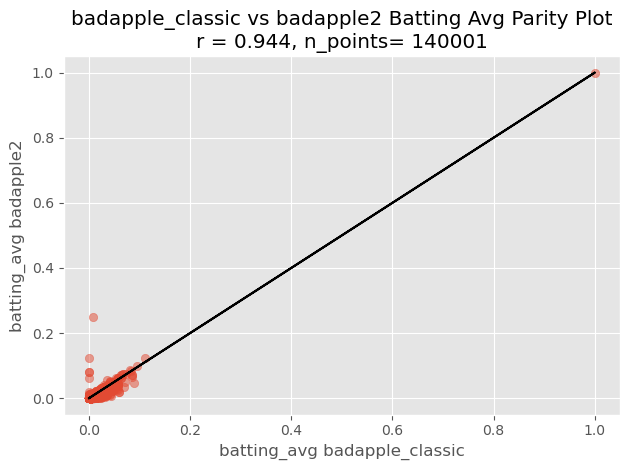

In [125]:
# visualize parity plot
plot_title = f"{ORIGINAL_DB_NAME} vs {COMPARISON_DB_NAME} Batting Avg Parity Plot\nr = %.3f, n_points= %d" % (correlation_nn, len(shared_batting_avg_df))
create_parity_plot(shared_batting_avg_df, ORIGINAL_BATTING_AVG_COL_NAME, COMPARISON_BATTING_AVG_COl_NAME, plot_title)
plt.show()

# Close DB connections

In [126]:
# Close the cursors
original_db_cur.close()
comparison_db_cur.close()

# Close the connections
original_db_connection.close()
comparison_db_connection.close()